In [51]:
%pip install pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.3 MB/s eta 0:00:0031m38.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ourpy]
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd

# Load CSV
df = pd.read_csv("typing_data/keystroke_data.csv")

# Convert timestamp to float
df["timestamp"] = df["timestamp"].astype(float)

# Sort by label and timestamp, just in case
df = df.sort_values(["valid", "timestamp"]).reset_index(drop=True)

# Compute time difference per user label
df["time_diff"] = df.groupby("valid")["timestamp"].diff().fillna(0)

# Mark a new sample when time_diff > threshold (e.g., 1.5 seconds)
THRESHOLD = 1.5
df["sample_id"] = (df["time_diff"] > THRESHOLD).cumsum()

# Combine sample_id with valid label to keep samples separate per user class
df["sample_id"] = df["valid"].astype(str) + "_" + df["sample_id"].astype(str)

# Your feature extractor function
def extract_features(events):
    features = {}
    down_times = {}
    last_down = None
    flight_times = []
    dwell_times = []
    
    for _, row in events.iterrows():
        if row["event_type"] == "down":
            down_times[row["key"]] = row["timestamp"]
            if last_down is not None:
                flight_times.append(row["timestamp"] - last_down)
            last_down = row["timestamp"]
        elif row["event_type"] == "up" and row["key"] in down_times:
            dwell_times.append(row["timestamp"] - down_times[row["key"]])
            del down_times[row["key"]]
    
    # Aggregate statistics (mean, std) for flight and dwell times
    if flight_times:
        features["flight_mean"] = sum(flight_times) / len(flight_times)
        features["flight_std"] = pd.Series(flight_times).std()
    else:
        features["flight_mean"] = 0
        features["flight_std"] = 0
    
    if dwell_times:
        features["dwell_mean"] = sum(dwell_times) / len(dwell_times)
        features["dwell_std"] = pd.Series(dwell_times).std()
    else:
        features["dwell_mean"] = 0
        features["dwell_std"] = 0
    
    return features

# Extract features per sample_id
feature_rows = []
for sample_id, group in df.groupby("sample_id"):
    feats = extract_features(group)
    # Assign the valid label from the first event in the group
    feats["valid"] = int(group["valid"].iloc[0])
    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows).fillna(0)


Accuracy:  0.8571
Precision: 1.0000
Recall:    0.7500
F1-Score:  0.8571
AUC:       0.9167


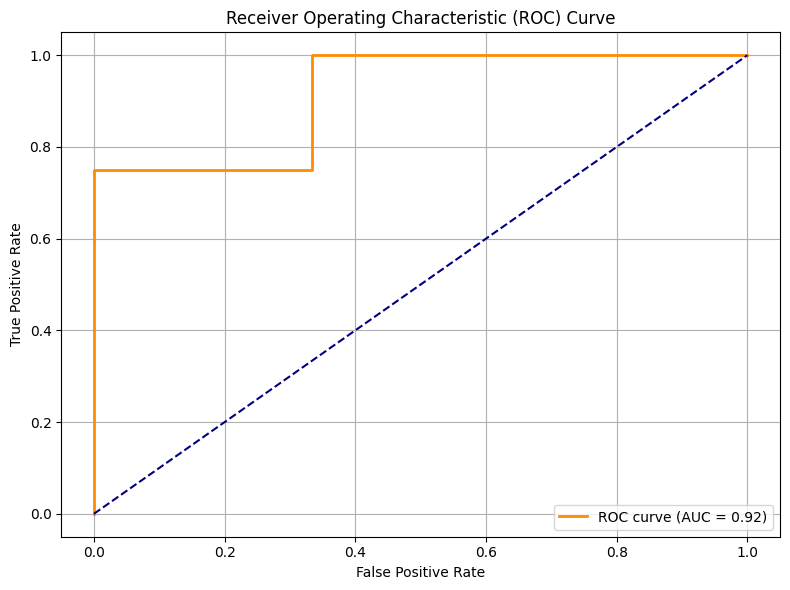

In [64]:
# Now train/test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt

X = features_df.drop(columns=["valid"])
y = features_df["valid"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()